# Data Loading

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# get data
data = pd.read_csv('./marked_data/result_with_parameters.csv')
data = data.drop("index", axis=1)

y = data["result"]
X = data.drop(["result"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2020, stratify=y)

# Scale Data

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

# Learning

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))
display(rfc.score(X_test_scaled, y_test))

1.0

0.7417539774932091

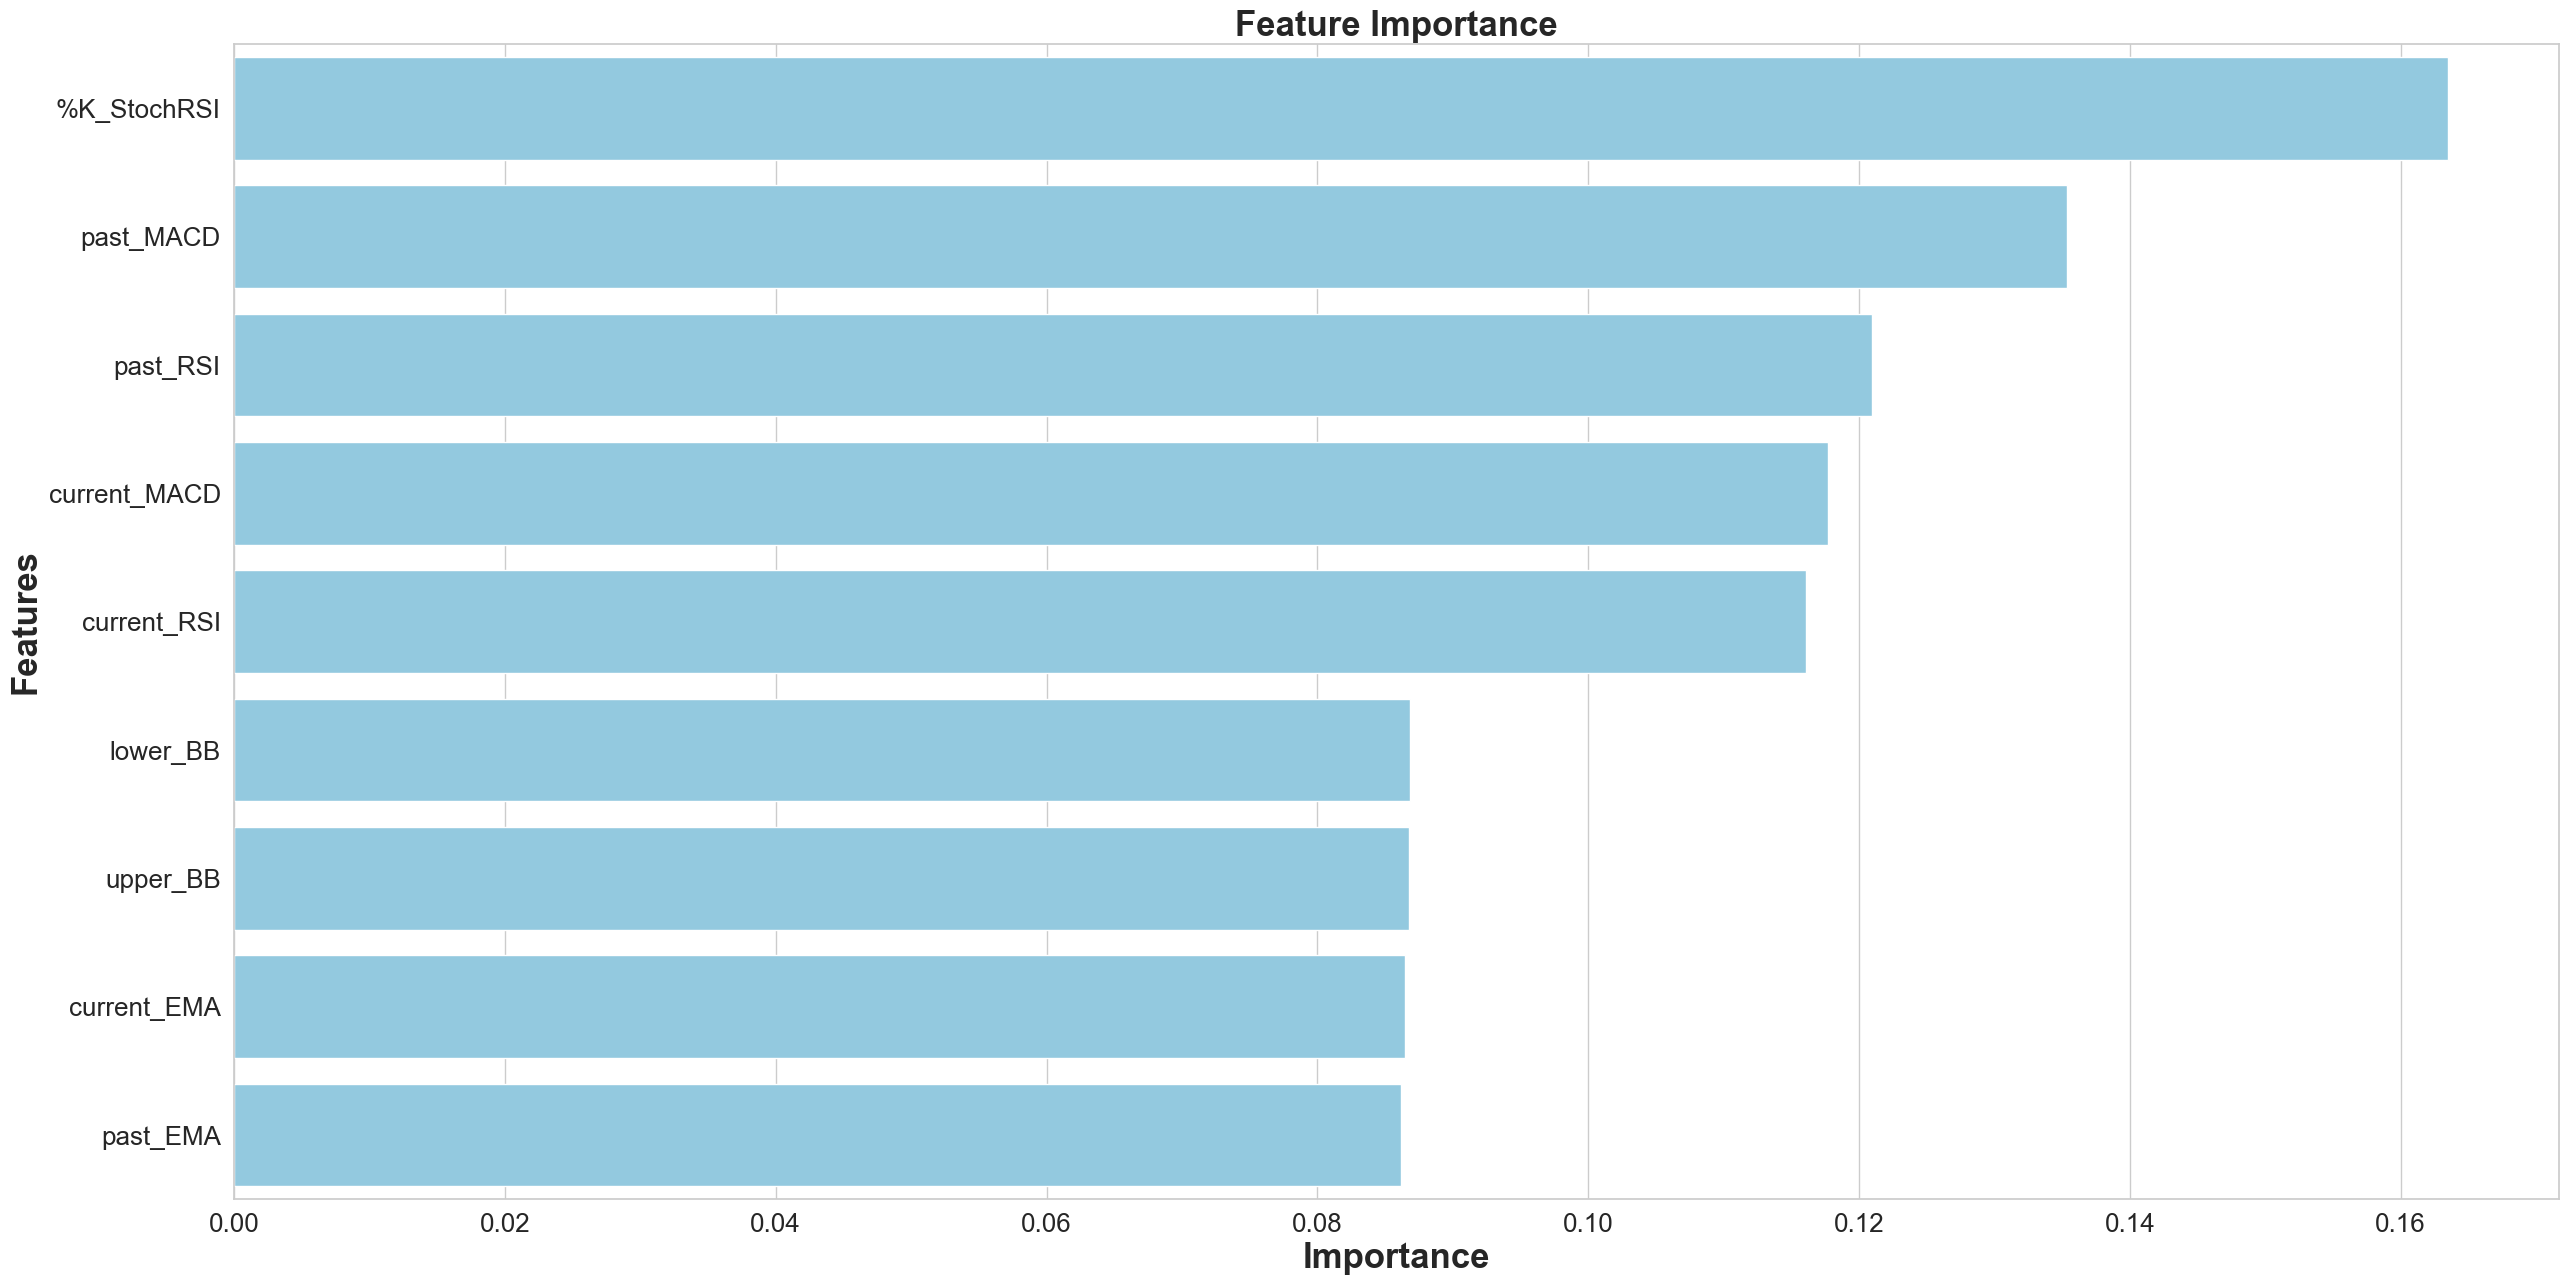

None

,Features,Gini-Importance
0,%K_StochRSI,0.163515
1,past_MACD,0.135365
2,past_RSI,0.120991
3,current_MACD,0.117731
4,current_RSI,0.116107
5,lower_BB,0.086868
6,upper_BB,0.086778
7,current_EMA,0.086454
8,past_EMA,0.086192


In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

feats = {}
for feature, importance in zip(data.drop("result", axis=1).columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [7]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 50,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 7,
 'bootstrap': False}

In [13]:
"""
just in case
{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 23,
 'max_features': 'log2',
 'max_depth': 14,
 'bootstrap': False}
"""


from sklearn.metrics import confusion_matrix, precision_score

y_pred_probs = rfc.predict_proba(X_test_scaled)[:, 1]

new_threshold = 0.5  # Example: setting a higher threshold

# Adjust the predicted labels based on the new threshold
y_pred = (y_pred_probs >= new_threshold).astype(int)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_baseline)
display('Baseline Random Forest recall score', precision_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,3477,393
actual 1,941,343


'Baseline Random Forest recall score'

0.46603260869565216